# Домашнє завдання: Побудова класифікатора сентименту на основі набору даних Tweet Sentiment Extraction

**Мета:** Провести аналіз набору даних, виконати векторизацію текстових даних за допомогою методів bag-of-words та TF-IDF, порівняти їх, побудувати класифікатор та провести аналіз помилок.

**Набір даних:**
Дані беремо з цього змагання на Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv


Якщо не вдається завантажиит з Kaggle, ось тут можна - https://drive.google.com/file/d/1kfu5zCRsDHxoBZigBlGIcCieKlws02HT/view?usp=sharing

Оригінальне змагання має дещо іншу задачу, але ми будемо поки будувати саме класифікатор.

Увага! В цьому наборі завдань для простоти експериментів ми будемо спочатку робити векторизацію на всьому наборі даних, а потім розбивку на train i test. В робочих проєктах ми теж можемо використати цей підхід для швидшої побудови PoC (proof of concept). Але фінальне рішення, яке ми будемо деплоїти - треба проводити за правилом - спочатку розбивка на трейн і тест, потім пишемо обробку для трейну, навчаємо векторизатори. І потім використовуємо готові векторизатори для тесту і всіх даних на етапі передбачення (інференсу).

### Завдання 1. Завантаження та ознайомлення з набором даних

- Завантажте набір даних `train.csv` з посилання та ознайомтеся з його структурою.
- Виведіть перші 5 рядків та основну статистику: кількість записів, типи колонок, кількість пропущених значень.
- Видаліть записи, в яких є пропущені значення.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls 'drive/MyDrive/ML_Course/Lessons_next'

'M_3_1_Методи кластеризації'	      'М_4_1_Вступ до NLP'
'M_3_2_Методи пониження розмірності'  'М_6_Створення додатків на базі LLM'


In [4]:
df = pd.read_csv("drive/MyDrive/ML_Course/Lessons_next/М_4_1_Вступ до NLP/data/tweet_sentiment_train.csv.zip")

In [5]:
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
df.shape

(27481, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [8]:
df = df.dropna()

Датасет, з яким сьогодні працюємо, має загалом 27481 запис та 4 колоночки. Він складається з id запису, безпосередньо тексту коментаря, виділеної частини з тексту (слово або декілька слів) які і є індикатором сентименту, і безпосередньо лейбли (таргет змінна).  
Тип даних для всіх колоночок object, в нашому випадку це текстові значення.  
Датасет містив лише 1 запис, що мав пропущені значення в колоночках text та selected_text

### Завдання 2. Exploratory Data Analysis

- Проведіть аналіз кількості класів та розподілу міток. Класи знаходяться в колонці `sentiment`.
- Візуалізуйте розподіл довжин текстів в символах та зробіть висновок про довжини постів: якої довжини постів найбільше, що бачите з розподілу?



In [9]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


Таргет змінна має 3 класи.  Найбільша кількість (11117 записів) має клас neutral, positive  та negative мають невеликі відмінності по кількості записів. В цілому, можна вважати що класи, плюс мінус, збалансовані.

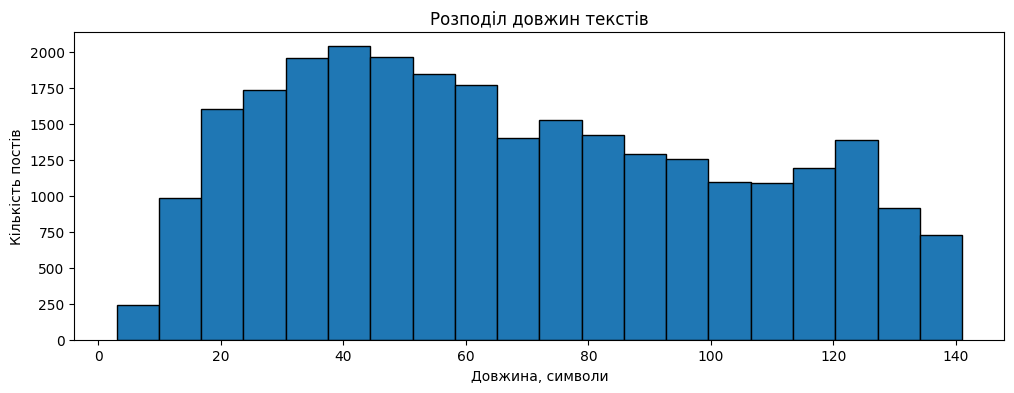

In [10]:
df['text_len'] = df['text'].astype(str).str.len()

plt.figure(figsize=(12,4))
df['text_len'].plot.hist(bins=20, edgecolor='black')
plt.xlabel('Довжина, символи')
plt.ylabel('Кількість постів')
plt.title('Розподіл довжин текстів')
plt.show();

In [11]:
df['text_len'].describe(percentiles=[.25, .50, .75, .80, .90])

,text_len
count,27480.000000
mean,68.330022
std,35.603870
min,3.000000
25%,39.000000
50%,64.000000
75%,97.000000
80%,105.000000
90%,122.000000
max,141.000000


In [12]:
df['text_len'].value_counts().head(10)

,count
text_len,
41,308
48,301
46,301
42,298
45,295
44,294
36,293
34,292
43,291


В середньому, твіти мають 68 символів. Майже 80% твітів мають довжину до 100 символів. Я думаю, що це пов'язано в цілому з обмеженнями на кількість символів, які можна використати за правилами даної соц мережі. Крім того, в твітері дуже розповсюджені скорочення та сленгові слова, які дозволяють скоротити текст. Зовсім коротких твітів, до 20 символів, найменше.

### Завдання 3. Попередня обробка текстових даних та векторизація з bag of words


Наша задача тут отримати вектори методом bag of words колонки `text`, виконавши попередню обробку тексту.
Попередня обробка має включати
- видалення stopwords необхідної мови
- токенізація (розбиття текстів на фрагменти по 1 слову)
- стеммінг слів зі `SnowballStemmer`.
- самостійно задайте кількість слів в словнику для `sklearn.feature_extraction.text.CountVectorizer`. Можливо для цього доведеться виконати додатковий аналіз.

Ви також можете додати сюди додаткові методи очистки текстів, наприклад, видалення деяких символів чи груп символів, якщо в процесі роботи побачите, що хочете щось видалити.

Напишіть код аби виконати це завдання. Перед цим рекомендую детально ознайомитись з тим, що робить обʼєкт `sklearn.feature_extraction.text.CountVectorizer` за замовченням.

Це завдання можна виконати двома способами - один - максимально подібно до того, як ми це робили в лекції, другий - дещо інакше перегрупувавши етапи обробки тексту.




In [13]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [16]:
english_stopwords = stopwords.words('english')
stemmer = SnowballStemmer(language='english')

In [17]:
def tokenize(text):
    punctuation = string.punctuation.replace('*', '')
    text = re.sub(f"[{re.escape(punctuation)}]", "", text)

    tokens = word_tokenize(text)

    tokens = [stemmer.stem(t) for t in tokens]

    return tokens

In [18]:
vectorizer = CountVectorizer(
    lowercase=True,
    tokenizer=tokenize,
    stop_words=english_stopwords
)

In [19]:
X = vectorizer.fit_transform(df['text'])

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'arent', 'becaus', 'befor', 'couldnt', 'didnt', 'doe', 'doesnt', 'dont', 'dure', 'hadnt', 'hasnt', 'havent', 'hed', 'hell', 'hes', 'id', 'ill', 'im', 'isnt', 'itd', 'itll', 'ive', 'mightnt', 'mustnt', 'neednt', 'onc', 'onli', 'ourselv', 'shant', 'shed', 'shell', 'shes', 'shouldnt', 'shouldv', 'thatll', 'themselv', 'theyd', 'theyll', 'theyr', 'theyv', 'veri', 'wasnt', 'wed', 'well', 'werent', 'weve', 'whi', 'wont', 'wouldnt', 'youd', 'youll', 'yourselv', 'youv'] not in stop_words.
  warnings.warn(


In [20]:
vocab = vectorizer.get_feature_names_out()
print(f"Розмір словника: {len(vocab)}")

Розмір словника: 24002


In [21]:
vocab

array(['*', '0', '00', ..., 'ï¿½ï¿½', 'ï¿½ï¿½h', 'ï¿½ï¿½ï¿½ï¿½'],
      dtype=object)

В словнику наявні дивні "слова". Дослідимо їх детальніше

In [22]:
s = df['text'].astype(str)

mask_replacement = s.str.contains(r'\uFFFD|ï¿½', regex=True)
mask_mojibake   = s.str.contains(r'(?:ï¿½){2,}', regex=True)

broken_mask = mask_replacement | mask_mojibake

non_ascii_mask = s.str.contains(r'[^\x00-\x7F]')

stats = {
    'rows_total': len(s),
    'broken_rows': int(broken_mask.sum()),
    'broken_share_%': round(100 * broken_mask.mean(), 2),
    'non_ascii_share_%': round(100 * non_ascii_mask.mean(), 2),
}
stats


{'rows_total': 27480,
 'broken_rows': 155,
 'broken_share_%': np.float64(0.56),
 'non_ascii_share_%': np.float64(0.57)}

In [23]:
examples = s[broken_mask].head(10).tolist()
examples

[' I love to! But I`m only available from 5pm.  and where dear? Would love to help  convert her vids.ï¿½',
 ' *phew*  Will make a note in case anyone else runs into the same issueï¿½',
 ' I love mine, too . happy motherï¿½s day to your mom , John Taylor  . much love to you, too .',
 'meeting just in time that iï¿½m trying to win something  prize`s friday!',
 'Just got confirmed that itï¿½s pizza-time with some ex co-workers on friday...looking forward to it',
 ' Well thatï¿½s disappointing to hear.',
 'today Jon Doe plays at the Moho. ia m excited  itï¿½s gonna be funny.. but before i have to carry all the equipment and do the backline',
 '_Guy Would luv to hear music too but iï¿½m out of batteries - the tv plays besides but i think this is some kind of vampire movie',
 'CCï¿½s video for Long Gone premiers today on yahoo, dont miss it: http://new.music.yahoo.com/videos/premieres/ AWESOME video and version',
 ' vocï¿½ que sumiu forever do msn.']

Загалом всього 155 твітів мають в собі такі дивні символи. Якщо аналізувати приклади таких твітів, то можна побачити, що частіше за все так невірно розпізнається апостраф, тобто це "битий" символ. Також, можна припустити, що в такі "биті" символи входять емодзі.

In [24]:
s_sel = df['selected_text'].astype(str)

mask_replacement_sel = s_sel.str.contains(r'\uFFFD|ï¿½', regex=True)
mask_mojibake_sel   = s_sel.str.contains(r'(?:ï¿½){2,}', regex=True)

broken_sel = mask_replacement_sel | mask_mojibake_sel


In [25]:
stats_sel = {
    'rows_total': len(s_sel),
    'broken_rows_selected_text': int(broken_sel.sum()),
    'broken_share_%_selected_text': round(100 * broken_sel.mean(), 2),
}
stats_sel


{'rows_total': 27480,
 'broken_rows_selected_text': 76,
 'broken_share_%_selected_text': np.float64(0.28)}

In [26]:
df.loc[broken_sel, 'sentiment'].value_counts(normalize=True)

,proportion
sentiment,
neutral,0.855263
positive,0.092105
negative,0.052632


In [27]:
df.loc[~broken_sel, 'sentiment'].value_counts(normalize=True)

,proportion
sentiment,
neutral,0.403299
positive,0.312911
negative,0.283791


Як бачимо, найбільша кількість битих (невірних) символів знаходяться саме в твітах з нейтральним забарвленням. Можемо замінити їх на '' - це не має вплинути на подальший аналіз.

In [28]:
df['text'] = df['text'].astype(str).str.replace(r'(?:ï¿½|\uFFFD)+', '', regex=True)

In [29]:
def remove_urls(text):
    return re.sub(r'http\S+|www\S+', '', text)

In [30]:
def tokenize_without_url(text):
    punctuation = string.punctuation.replace('*', '')
    text = remove_urls(text)
    text = re.sub(f"[{re.escape(punctuation)}]", "", text)

    tokens = word_tokenize(text)

    tokens = [stemmer.stem(t) for t in tokens]

    return tokens

In [31]:
vectorizer = CountVectorizer(
    lowercase=True,
    tokenizer=tokenize_without_url,
    stop_words=english_stopwords
)
X = vectorizer.fit_transform(df['text'])
vocab = vectorizer.get_feature_names_out()
print(f"Розмір словника: {len(vocab)}")

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'arent', 'becaus', 'befor', 'couldnt', 'didnt', 'doe', 'doesnt', 'dont', 'dure', 'hadnt', 'hasnt', 'havent', 'hed', 'hell', 'hes', 'id', 'ill', 'im', 'isnt', 'itd', 'itll', 'ive', 'mightnt', 'mustnt', 'neednt', 'onc', 'onli', 'ourselv', 'shant', 'shed', 'shell', 'shes', 'shouldnt', 'shouldv', 'thatll', 'themselv', 'theyd', 'theyll', 'theyr', 'theyv', 'veri', 'wasnt', 'wed', 'well', 'werent', 'weve', 'whi', 'wont', 'wouldnt', 'youd', 'youll', 'yourselv', 'youv'] not in stop_words.
  warnings.warn(


Розмір словника: 22644


In [32]:
vocab

array(['*', '0', '00', ..., 'zzzzi', 'zzzzzzzgoodnight',
       'zzzzzzzzzzzzzzz'], dtype=object)

Розмір отриманого словника = 22644 слова. Це дуже багато, то ж спробуємо скоротити його для подальшого аналізу

In [33]:
import numpy as np

In [34]:
word_freq = np.asarray(X.sum(axis=0)).ravel()
freq_df = (
    pd.DataFrame({'word': vocab, 'count': word_freq})
      .sort_values(by='count', ascending=False)
)
print(freq_df.head(60))

           word  count
0             *   4952
9977         im   3056
5446        day   2370
8367         go   2363
8191        get   1908
8425       good   1569
21988      work   1483
11960      love   1458
11632      like   1454
8506        got   1239
6098       dont   1202
19864     today   1114
19757      time   1079
14330       one   1055
3836       cant   1028
9007      happi    993
21331      want    981
11140      know    969
19442     thank    962
12905      miss    961
11806       lol    951
20559         u    923
16165    realli    909
2269       back    897
17223       see    893
19580     think    875
7252       feel    869
13182    mother    788
9590       hope    782
13747     night    778
12228      make    751
21552      well    746
13654       new    740
9508       home    725
11872      look    715
13443        na    703
13574      need    695
18600     still    679
294           2    666
14198        oh    664
13296      much    660
21389     watch    646
4672       

Для подальших експериментів, визначимо, яка кількість слів покриває 90% всіх твітів, щоб спробувати визначити необхідну кількість слів (фіч)

In [35]:
freq_df = freq_df.sort_values(by='count', ascending=False)
freq_df['cum_sum'] = freq_df['count'].cumsum()
freq_df['cum_perc'] = freq_df['cum_sum'] / freq_df['count'].sum()

n_words_90 = freq_df[freq_df['cum_perc'] <= 0.9].shape[0]
print(f"Щоб покрити 90% усіх вживань, потрібно {n_words_90} слів.")


Щоб покрити 90% усіх вживань, потрібно 5297 слів.


Для порівняння різних підходів, спробуємо векторизувати наші твіти трьома способами.

max_features = 6000 слів (покривають 90% всіх твітів)

In [36]:
vectorizer_max_feat = CountVectorizer(
    lowercase=True,
    tokenizer=tokenize_without_url,
    stop_words=english_stopwords,
    max_features=6000
)
X_max_feat = vectorizer_max_feat.fit_transform(df['text'])
vocab_max_feat = vectorizer_max_feat.get_feature_names_out()
print(f"Розмір словника: {len(vocab_max_feat)}")

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'arent', 'becaus', 'befor', 'couldnt', 'didnt', 'doe', 'doesnt', 'dont', 'dure', 'hadnt', 'hasnt', 'havent', 'hed', 'hell', 'hes', 'id', 'ill', 'im', 'isnt', 'itd', 'itll', 'ive', 'mightnt', 'mustnt', 'neednt', 'onc', 'onli', 'ourselv', 'shant', 'shed', 'shell', 'shes', 'shouldnt', 'shouldv', 'thatll', 'themselv', 'theyd', 'theyll', 'theyr', 'theyv', 'veri', 'wasnt', 'wed', 'well', 'werent', 'weve', 'whi', 'wont', 'wouldnt', 'youd', 'youll', 'yourselv', 'youv'] not in stop_words.
  warnings.warn(


Розмір словника: 6000


Прибираємо слова, що зустрічаються рідше 2 разів

In [37]:
vectorizer_min_df = CountVectorizer(
    lowercase=True,
    tokenizer=tokenize_without_url,
    stop_words=english_stopwords,
    min_df=2
)
X_min_df = vectorizer_min_df.fit_transform(df['text'])
vocab_min_df = vectorizer_min_df.get_feature_names_out()
print(f"Розмір словника: {len(vocab_min_df)}")

Розмір словника: 8148


max_features = 2000 слів

In [38]:
vectorizer_min = CountVectorizer(
    lowercase=True,
    tokenizer=tokenize_without_url,
    stop_words=english_stopwords,
    max_features=2000
)
X_min = vectorizer_min.fit_transform(df['text'])
vocab_min = vectorizer_min.get_feature_names_out()
print(f"Розмір словника: {len(vocab_min)}")

Розмір словника: 2000


### Завдання 4. Побудова класифікатора

- Розділіть індекси даних на навчальний та тестовий набори в обраному співвівдношенні. Використовуючи отримані індекси сфомуйте набори для тренування класифікатора `X_train_bow, X_test_bow, y_train, y_test`.
- Навчіть класифікатор (наприклад, Logistic Regression, Decision Tree або один з алгоритмів бустингу) на даних, векторизованих методом bag-of-words. Спробуйте кілька моделей і оберіть найбільш точну :)
- Виведіть інформацію, яка дає можливість оцінити якість класифікації.
- Оцініть якість фінальної класифікації: вона хороша чи не дуже?



In [39]:
from sklearn.model_selection import train_test_split

In [40]:
y = df['sentiment']

Набори для 6000 слів

In [41]:
X_train_max_feat, X_test_max_feat, y_train_max_feat, y_test_max_feat = train_test_split(
    X_max_feat,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

Набори для 8148 слів

In [42]:
X_train_min_df, X_test_min_df, y_train_min_df, y_test_min_df = train_test_split(
    X_min_df,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

Набори для 2000 слів

In [43]:
X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(
    X_min,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

In [45]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

Тренуємо модель для 6000 ознак

In [46]:
results = {}

for name, model in models.items():
    model.fit(X_train_max_feat, y_train_max_feat)
    y_pred = model.predict(X_test_max_feat)

    acc = accuracy_score(y_test_max_feat, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test_max_feat, y_pred, digits=3))
    results[name] = acc


=== Logistic Regression ===
Accuracy: 0.6832
              precision    recall  f1-score   support

    negative      0.694     0.626     0.659      2334
     neutral      0.631     0.712     0.669      3335
    positive      0.755     0.697     0.725      2575

    accuracy                          0.683      8244
   macro avg      0.694     0.679     0.684      8244
weighted avg      0.688     0.683     0.684      8244


=== Decision Tree ===
Accuracy: 0.6371
              precision    recall  f1-score   support

    negative      0.611     0.631     0.621      2334
     neutral      0.627     0.597     0.612      3335
    positive      0.672     0.694     0.683      2575

    accuracy                          0.637      8244
   macro avg      0.637     0.641     0.639      8244
weighted avg      0.637     0.637     0.637      8244


=== Gradient Boosting ===
Accuracy: 0.6593
              precision    recall  f1-score   support

    negative      0.757     0.467     0.577      2334

Тренуємо модель для 8148 ознак

In [47]:
results = {}

for name, model in models.items():
    model.fit(X_train_min_df, y_train_min_df)
    y_pred = model.predict(X_test_min_df)

    acc = accuracy_score(y_test_min_df, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test_min_df, y_pred, digits=3))
    results[name] = acc


=== Logistic Regression ===
Accuracy: 0.6816
              precision    recall  f1-score   support

    negative      0.690     0.627     0.657      2334
     neutral      0.629     0.710     0.667      3335
    positive      0.757     0.694     0.724      2575

    accuracy                          0.682      8244
   macro avg      0.692     0.677     0.683      8244
weighted avg      0.686     0.682     0.682      8244


=== Decision Tree ===
Accuracy: 0.6397
              precision    recall  f1-score   support

    negative      0.612     0.622     0.617      2334
     neutral      0.635     0.597     0.615      3335
    positive      0.670     0.711     0.690      2575

    accuracy                          0.640      8244
   macro avg      0.639     0.643     0.641      8244
weighted avg      0.639     0.640     0.639      8244


=== Gradient Boosting ===
Accuracy: 0.6589
              precision    recall  f1-score   support

    negative      0.754     0.468     0.577      2334

Тренуємо модель для 2000 ознак

In [48]:
results = {}

for name, model in models.items():
    model.fit(X_train_min, y_train_min)
    y_pred = model.predict(X_test_min)

    acc = accuracy_score(y_test_min, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test_min, y_pred, digits=3))
    results[name] = model


=== Logistic Regression ===
Accuracy: 0.6836
              precision    recall  f1-score   support

    negative      0.700     0.611     0.653      2334
     neutral      0.628     0.726     0.673      3335
    positive      0.761     0.694     0.726      2575

    accuracy                          0.684      8244
   macro avg      0.696     0.677     0.684      8244
weighted avg      0.690     0.684     0.684      8244


=== Decision Tree ===
Accuracy: 0.6274
              precision    recall  f1-score   support

    negative      0.597     0.609     0.603      2334
     neutral      0.618     0.589     0.603      3335
    positive      0.666     0.693     0.679      2575

    accuracy                          0.627      8244
   macro avg      0.627     0.631     0.628      8244
weighted avg      0.627     0.627     0.627      8244


=== Gradient Boosting ===
Accuracy: 0.6582
              precision    recall  f1-score   support

    negative      0.764     0.461     0.575      2334

За результатами оцінки якості натренованих моделей, можна сказати, що Logistic Regression на 2000 слів відпрацювала найкраще.  
1. Маємо найвищий показник точності 0.684, макро та зважений f1, з таким самим значенням. Це означає, що модель непогано тримає баланс між всіма класами. Немає прям явного перекосу в домінуючий клас.  
2. f1 по кожному класу окремо так само на найвищому рівні.  
3. precision / recall: модель дуже непогано визначає positive клас, знаходить багато neutral твітів (recall 0.726) але частіше плутає їх з іншими класами. Трохи обережніша з визначенням negative твітів, проте все ще знахидить 60%.  
4. Використаний простіший словник, отже менше ризику переобучення, менше пам’яті, швидше навчання.

### Завдання 5. Аналіз впливовості слів в отриманого класифікатора

- Для обраної вами моделі проведіть аналіз важливості слів (ознак): які слова (токени) найбільше впливають для визначення сентименту? Чи це логічно на ваш погляд, що саме ці символи впливають найбільше/найменще?


In [49]:
feature_importance = pd.Series(results['Logistic Regression'].coef_[0], index=vectorizer_min.get_feature_names_out(), name='imp').sort_values(ascending=False)
feature_importance

,imp
sad,2.567593
suck,2.483479
hate,2.241413
sorri,2.182142
bore,2.160790
...,...
thank,-2.014120
beauti,-2.054504
love,-2.207028
glad,-2.242284


З виведених коефіцієнтів важливості слів, можемо прослідкувати чітку відмінність і логічність в наборах, що впливають на вибір negative та positive класів.

In [50]:
feature_importance[(feature_importance >= -0.5) & (feature_importance <= 0.5)]

,imp
ohh,0.499504
swollen,0.499234
knee,0.496518
cnt,0.496071
fruit,0.494322
...,...
pic,-0.494210
video,-0.496768
14,-0.497224
da,-0.497226


Як бачимо, слова, що мають значно менші коефіцієнти важливості, не несуть в собі явного сентиментального забарвлення (ані позитивного, ані негативного)

### Завдання 6. Векторизація текстів з допомогою TF-IDF. Тренування класифікатора, аналіз точності і впливовості слів.

- Проведіть векторизацію текстів з векторизатором TfidfVectorizer. Реалізуйте векторизацію так, аби препроцесинг включав всі ті самі кроки, що і в випадку використання векторизації Bag of Words.

- Натренуйте той самий класифікатор на TF-IDF векторах, виконавши розбивку набору даних на train, test так, аби в трейні були всі ті самі записи, що і були в попередньому завданні (це важливо для порівняння результатів).

- Проаналізуйте якість класифікації вивівши потрібні для цього метрики. Чи стала якість класифікації кращою?

- Які токени найбільше впливають на результат при тренуваннні класифікатора з TF-IDF векторами? Порівняйте з найважливішими токенами при Bag of Words векторизації. Яку векторизацію ви б обрали для фінальної імплементації рішення? Обґрунтуйте свій вибір.



In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,
    tokenizer=tokenize_without_url,
    stop_words=english_stopwords,
    max_features=2000
)
X_tfidf = tfidf_vectorizer.fit_transform(df['text'])
vocab_tfidf = tfidf_vectorizer.get_feature_names_out()

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'arent', 'becaus', 'befor', 'couldnt', 'didnt', 'doe', 'doesnt', 'dont', 'dure', 'hadnt', 'hasnt', 'havent', 'hed', 'hell', 'hes', 'id', 'ill', 'im', 'isnt', 'itd', 'itll', 'ive', 'mightnt', 'mustnt', 'neednt', 'onc', 'onli', 'ourselv', 'shant', 'shed', 'shell', 'shes', 'shouldnt', 'shouldv', 'thatll', 'themselv', 'theyd', 'theyll', 'theyr', 'theyv', 'veri', 'wasnt', 'wed', 'well', 'werent', 'weve', 'whi', 'wont', 'wouldnt', 'youd', 'youll', 'yourselv', 'youv'] not in stop_words.
  warnings.warn(


In [53]:
n = X_min.shape[0]
idx = np.arange(n)

train_idx, test_idx = train_test_split(
    idx,
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_train = X_tfidf[train_idx]
X_test  = X_tfidf[test_idx]
y_arr  = y.to_numpy() if hasattr(y, "to_numpy") else np.asarray(y)
y_train = y_arr[train_idx]
y_test  = y_arr[test_idx]

In [54]:
model_tfidf = LogisticRegression(max_iter=1000, random_state=42)
model_tfidf.fit(X_train, y_train)
y_pred = model_tfidf.predict(X_test)

print(classification_report(y_test_min, y_pred, digits=3))

              precision    recall  f1-score   support

    negative      0.710     0.611     0.656      2334
     neutral      0.628     0.743     0.681      3335
    positive      0.773     0.687     0.728      2575

    accuracy                          0.688      8244
   macro avg      0.704     0.680     0.688      8244
weighted avg      0.696     0.688     0.688      8244



In [55]:
feature_importance_tfidf = pd.Series(model_tfidf.coef_[0], index=tfidf_vectorizer.get_feature_names_out(), name='imp').sort_values(ascending=False)
feature_importance_tfidf

,imp
sad,4.900572
miss,4.561840
hate,4.222294
sorri,4.145863
suck,4.142890
...,...
glad,-2.872952
hope,-3.155094
awesom,-3.423780
thank,-3.700186


Модель натренована з Tf-IDF показала кращі результати.  
1. Збільшилась точність до 0.69, а також макро та зважений f1
2. Класові f1 також збільшились по всіх класах.
3. Коефіцієнти важливості слів залишаються так само логічними і зрозумілими

### Завдання 7. Аналіз помилок класифікації з векторизацією TF-IDF.

- Проаналізуйте, на яких екземплярах помиляється класифікатор при векторизації TF-IDF.
- На основі аналізу запропонуйте 3 шляхи поліпшення якості класифікації.

In [56]:
df['predicts'] = model_tfidf.predict(X_min)

In [57]:
df['error'] = df.sentiment != df.predicts

In [58]:
df[df['error'] == 1]['sentiment'].value_counts()

,count
sentiment,
neutral,5166
negative,1754
positive,1239


In [59]:
df[df['error'] == 1].head(50)

,textID,text,selected_text,sentiment,text_len,predicts,error
2,088c60f138,my boss is bullying me...,bullying me,negative,25,neutral,True
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,positive,True
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,92,positive,True
7,50e14c0bb8,Soooo high,Soooo high,neutral,10,negative,True
10,2339a9b08b,"as much as i love to be hopeful, i reckon the...","as much as i love to be hopeful, i reckon the ...",neutral,107,positive,True
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative,44,neutral,True
20,04d17ef61e,"oh Marly, I`m so sorry!! I hope you find her...","oh Marly, I`m so sorry!! I hope you find her ...",neutral,59,positive,True
24,0c8cc71c46,SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cA...,SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cA...,neutral,79,negative,True
27,bdc32ea43c,On the way to Malaysia...no internet access to...,.no internet,negative,51,neutral,True
29,d22e6d40a7,Went to sleep and there is a power cut in Noid...,Power back up not working too,negative,78,neutral,True


Найбільша кількість помилок на neutral класі. На позитивному та негативному кількість помилок значно не відрізняється.  
З чим, на мій погляд, можуть бути пов'язані помилки:  
- використаний словник стоп слів видалив всі слова, що в лексиці англійської мови явно вказують на заперечення, наприклад, в оригіналі було 'not good', ми прибрали not і, відповідно, рішення моделі базується виключно на слові good, яке має високий коефіцієнт значущості;  
- також, я прибрала знаки пунктуації, не врахувавши, що такі послідовності як '!!!!!', '?????', '???!!!!!' тощо можуть впливати на емоційне забарвлення тексту;  
- текст капс локом. Це зазвичай також є ознакою емоційного забарвлення, ми нівелювали це препроцесингом;
- сленг та загально прийняті скорочення типу 'idk';  
- невірно написані слова (з повторенням літер - 'BADDD');
- для нейтральних твітів іноді одне єдине слово, що має високий коефіцієнт важливості, спотрворює результат, навіть якщо весь твіт цілком дійсно не несе негативного забарвлення.  

Як можна покращити результати:  
- створити кастомний список стоп слів
- використати ngram_range
- можна створити додаткову змінну, в чку записувати частку великих літер в усьому твіті
- створити спеціальний словник з розшифровкою скорочень та сленгових слів
- використовувати для моделі не text, а selected_text

І на фінал кернел для натхнення і ознайомлення з рішенням оригінальної задачі. Багато цікавих візуалізацій і аналізу є тут, а також тут розвʼязується саме проблема named entitty recognition і можна ознайомитись як це робиться - вона дещо складніша по своїй суті ніж класифікація, подумайте, чому:

https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model